# Born to slide: mobile origin licensing factors confer resistance to transcription conflicts

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 1H
+ S1I
+ S1J
+ S1K

#### Archives:
+ MCM_high-salt_diffusion.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from marspy.stats import bootstrap, calc_ci
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['MCM_high-salt_diffusion.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure1/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure1/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
MCM_high-salt_diffusion,14,22,ybbR-LD655-MCM,ATP,True,n/a,False,passed


### Functions

In [9]:
def calc_msd(df, prefix, msd_col, time_col, tau=1, start=np.nan, end=np.nan):
    '''
    Calculates mean square displacement of molecules.
    Remove pairs with missing slices in interval, do not drop NaN values!
    *df: dataframe
    *prefix: protein prefix
    *msd_col: column in df to calculate msd (without protein prefix!)
    *time_col: time column in df (without protein prefix!)
    *tau: time delta used to calculate msd (without protein prefix!)
    
    returns (msd, dtime)
    msd: mean squared error
    dtime: mean time difference underlying msd calculation
    '''
    # if not start / end was specified by used, set to max range
    if np.isnan(start):
        start=df[prefix+time_col].iloc[0]
        
    if np.isnan(end):
        end=df[prefix+time_col].iloc[-1]
    
    # will be a more accurate way to calculate MSD due to existing NaN values
    diffs = []
    dtimes = []
    for row in df.index:
            try:
                # check if sliding window range
                if (df.loc[row, prefix+time_col] >= start and df.loc[row+tau, prefix+time_col] <= end):
                    
                    # check if we have consecutive frames (slices) which are not null
                    if (((df.loc[row+tau, prefix+'slice'] - df.loc[row, prefix+'slice']) == tau) and not
                        ((np.isnan(df.loc[row+tau, prefix+msd_col]) or np.isnan(df.loc[row, prefix+msd_col])))):
                        
                        diffs.append(df.loc[row+tau, prefix+msd_col] - df.loc[row, prefix+msd_col])
                        dtimes.append(df.loc[row+tau, prefix+time_col] - df.loc[row, prefix+time_col])

                    else:
                        #skip to next row
                        continue
                
            # end of df
            except KeyError:
                break
            
    return np.mean(np.square(diffs)), np.mean(dtimes)

### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''Sets up a 2-level df with all relevant information'''
    #indices will be UIDs
    #outside: set comprehension to cover all possible prefixes in all instances
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['lifetime', 'initial_intensity', 'sliding_start', 'sliding_end', 'msd', 'dtime', 'd_coeff']

    hier_index = pd.MultiIndex.from_product([col_1,col_2],names=['molecule','properties'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(MCM_1_, d_coeff), (MCM_1_, dtime), (MCM_1_, initial_intensity), (MCM_1_, lifetime), (MCM_1_, msd), (MCM_1_, sliding_end), (MCM_1_, sliding_start), (MCM_2_, d_coeff), (MCM_2_, dtime), (MCM_2_, initial_intensity), (MCM_2_, lifetime), (MCM_2_, msd), (MCM_2_, sliding_end), (MCM_2_, sliding_start)]
Index: []

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        # general columns first
        # this could be generalized with mol prefixes
        df.loc[molecule.uid,'number_mcm'] = molecule.params['Number_MCM']
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()

        for prefix in molecule.prefixes:
            
            # lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            # take intensity from mean of first 20 frames
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df[prefix+'Intensity'].iloc[0:20].mean()
            
            # a specific region was defined
            if 'sliding_'+prefix in list(filter(lambda region: 'sliding' in region.name, molecule.regions))[0].name:
                
                # temporary variables
                start = archive.archive_link.get(molecule.uid).getRegion('sliding_'+prefix).getStart()
                end = archive.archive_link.get(molecule.uid).getRegion('sliding_'+prefix).getEnd()
                
                # sliding window start & end
                df.loc[molecule.uid,(prefix,'sliding_start')] = start
                df.loc[molecule.uid,(prefix,'sliding_end')] = end
            
                # MSD (kbp^2) & dtime (s)
                
                msd, dtime = calc_msd(df=molecule.df, prefix=prefix, msd_col='Position_on_DNA', time_col='Time (s)', 
                                      tau=1, start=start, end=end)
                df.loc[molecule.uid,(prefix,'msd')] = msd/(1000**2)
                df.loc[molecule.uid,(prefix,'dtime')] = dtime
                
                # diffusion coefficient (kpb^2/s)
                df.loc[molecule.uid,(prefix,'d_coeff')] = df.loc[molecule.uid,(prefix,'msd')] / (2*df.loc[molecule.uid,(prefix,'dtime')])
                
            #no region => molecule was not sliding
            else:
                pass            
            
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


In [13]:
df.head()

molecule                   MCM_1_                                       \
properties                d_coeff     dtime initial_intensity lifetime   
kko5UzrqAZnguokDqP3f8h  30.774663  0.204567          8198.050      125   
dGuAtTcAmPSfVtVYrAzS8r  14.916423  0.204782        153933.250      111   
i3jxh2yfvPTSwbGTcqZbft   4.184625  0.204585        370106.700      209   
kP7w4KyVzn7tkuVio9YucC  10.096878  0.204566        383426.525      174   
9fEuFDKneXU8ewyRAbhbf   30.370401  0.204016         19275.550      152   

molecule                                                     MCM_2_        \
properties                    msd sliding_end sliding_start d_coeff dtime   
kko5UzrqAZnguokDqP3f8h  12.590941      26.169         0.000     NaN   NaN   
dGuAtTcAmPSfVtVYrAzS8r   6.109225      22.526         0.000     NaN   NaN   
i3jxh2yfvPTSwbGTcqZbft   1.712226      43.144         0.000     NaN   NaN   
kP7w4KyVzn7tkuVio9YucC   4.130965      35.390         0.000     NaN   NaN   
9fEuFDKneXU8ewyRAbhbf   12.392119      34.780        15.765     NaN   NaN   

molecule                                                           \
properties             initial_intensity lifetime msd sliding_end   
kko5UzrqAZnguokDqP3f8h               NaN      NaN NaN         NaN   
dGuAtTcAmPSfVtVYrAzS8r               NaN      NaN NaN         NaN   
i3jxh2yfvPTSwbGTcqZbft               NaN      NaN NaN         NaN   
kP7w4KyVzn7tkuVio9YucC               NaN      NaN NaN         NaN   
9fEuFDKneXU8ewyRAbhbf                NaN      NaN NaN         NaN   

molecule                             dna_length nucleotide number_mcm  \
properties             sliding_start                                    
kko5UzrqAZnguokDqP3f8h           NaN  41.866500        ATP        1.0   
dGuAtTcAmPSfVtVYrAzS8r           NaN  40.837251        ATP        1.0   
i3jxh2yfvPTSwbGTcqZbft           NaN  43.054197        ATP        1.0   
kP7w4KyVzn7tkuVio9YucC           NaN  41.750331        ATP        1.0   
9fEuFDKneXU8ewyRAbhbf            NaN  36.842738        ATP        1.0   

molecule                    tags  
properties                        
kko5UzrqAZnguokDqP3f8h  [accept]  
dGuAtTcAmPSfVtVYrAzS8r  [accept]  
i3jxh2yfvPTSwbGTcqZbft  [accept]  
kP7w4KyVzn7tkuVio9YucC  [accept]  
9fEuFDKneXU8ewyRAbhbf   [accept]

## Figures

### Figure 1H: Diffusion coefficient salt-sliding MCMs

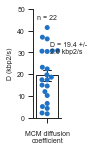

In [14]:
protein = 'MCM'

fig,axes = plt.subplots(figsize=(0.5,2))

sns.barplot(y=df['MCM_1_']['d_coeff'],palette=palettes[protein][1:2], lw=1 , edgecolor='.15', capsize=.3,facecolor=(1, 1, 1, 0),
            errwidth=1,ax=axes,n_boot=10000, seed=42, ci=68, errcolor='.15')
sns.swarmplot(y=df['MCM_1_']['d_coeff'],palette=palettes[protein][1:2],ax=axes)

axes.set_ylim(0,50)
#axes.set_title('Observed MCM diffusion in 0.5 M NaCl')
axes.set_ylabel('D (kbp2/s)')
axes.text(0.5, 0.95, f"n = {len(df['MCM_1_']['d_coeff'])}",
        verticalalignment='top', horizontalalignment='center',
        transform=axes.transAxes)
axes.text(0.6, 0.7, f"D = {round(df['MCM_1_']['d_coeff'].mean(),1)} +/- \n{round(df['MCM_1_']['d_coeff'].sem(),1)} kbp2/s",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes)
axes.set_xlabel('MCM diffusion\ncoefficient')
# tidy up
#plt.tight_layout()
sns.despine()

# save
plt.savefig(dir_out+"1H_MCM_diffusionCoeff.svg",transparent=True)

### Figure S1I: Probability of MCM sliding in high salt

In [15]:
import scyjava as sc

In [16]:
total_mcm_count = 0
for metadata in DnaMoleculeArchive.instances[0].metadata_uids:
    total_mcm_count += dict(sc.to_python(DnaMoleculeArchive.instances[0].archive_link.getMetadata(metadata).
                                         getParameters()))['TotalMcmCount']
total_mcm_count

2120.0

In [17]:
df_pslide = pd.DataFrame(data={'non-diffusive':(total_mcm_count-len(DnaMoleculeArchive.instances[0])) / total_mcm_count,
                               'diffusive':len(DnaMoleculeArchive.instances[0]) / total_mcm_count,
                               'total':total_mcm_count}.items(),
                         columns = ['population','count'])
df_pslide.set_index('population',inplace=True)

In [18]:
df_pslide

,count
population,
non-diffusive,0.989623
diffusive,0.010377
total,2120.000000


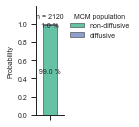

In [19]:
protein = 'MCM'
fig,axes = plt.subplots()

df_pslide.iloc[0:-1].T.plot(kind='bar',stacked=True, figsize=(0.5,2),ax=axes,color=palettes['qualitative'][0::2],lw=0.5,edgecolor='.15')
axes.set_ylabel("Probability")
#axes.set_title("MCM populations")
axes.set_ylim([0,1.19])
axes.legend(title='MCM population',frameon=False, bbox_to_anchor=[1, 1], loc='upper left')
for item in axes.get_xticklabels():
    item.set_rotation(45)

labels = [int(df_pslide.loc['total',column]) for column in df_pslide.columns]


#calculate y offset to label bars on top
dy = []
for column in df_pslide.columns:
    temp_sum = 0
    for index,row in df_pslide.iterrows():
        if (index == 'total'):
            continue
        else:
            temp_sum+=df_pslide.loc[index,column]
    dy.append(temp_sum)
rects = axes.patches
counter = 0
for rect, label in zip(rects, labels):
    height = dy[counter]
    axes.text(rect.get_x() + rect.get_width()/2, height+0.05, s=f"n = {label}", ha='center', va='bottom')
    axes.text(rect.get_x() + rect.get_width()/2, 0.45, s=f"{round(df_pslide.loc['non-diffusive','count']*100,1)} %", ha='center', va='bottom')
    axes.text(rect.get_x() + rect.get_width()/2, 0.95, s=f"{round(df_pslide.loc['diffusive','count']*100,1)} %", ha='center', va='bottom')
    counter+=1
    
axes.set_xticklabels([])
#tidy up
#fig.tight_layout()
sns.despine()

#save
plt.savefig(dir_out+"S1I_MCM_Populations.svg",transparent=True)

In [20]:
# estimate standard error by bootstrapping (skip)

In [21]:
df_pslide.columns = ['probability']
df_pslide

,probability
population,
non-diffusive,0.989623
diffusive,0.010377
total,2120.000000


In [22]:
for row in df_pslide.index[:-1]:
    bootstrap_data = ([0 for _ in range(int((1-df_pslide.loc[row,'probability'])*df_pslide.loc['total','probability']))] +
                          [1 for _ in range(int(df_pslide.loc[row,'probability']*df_pslide.loc['total','probability']))])
    bootstrap_means = bootstrap(bootstrap_data,n_boot=10000)
    df_pslide.loc[row,'bs_mean'] = np.mean(bootstrap_means)
    df_pslide.loc[row,'standard_error'] = np.std(bootstrap_means)
    df_pslide.loc[row,'68_ci_lower'], df_pslide.loc[row,'68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
    df_pslide.loc[row,'95_ci_lower'], df_pslide.loc[row,'95_ci_upper'] = calc_ci(bootstrap_means,ci=95)

In [23]:
df_pslide

,probability,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
population,,,,,,,
non-diffusive,0.989623,0.989590,0.002210,0.987264,0.991981,0.984906,0.993868
diffusive,0.010377,0.010358,0.002207,0.008019,0.012736,0.006132,0.014623
total,2120.000000,NaN,NaN,NaN,NaN,NaN,NaN


### Figure S1J: MSD vs dtime

In [24]:
# Generate separate dfs with MSD for different tau
dfs_msd = []
for molecule in DnaMoleculeArchive.instances[0].molecules:
    df_temp = pd.DataFrame()
    for i in range(0,11):

        msd, dtime = calc_msd(molecule.df, prefix='MCM_1_', 
                              msd_col='Position_on_DNA', time_col='Time (s)', 
                              tau=i, start=df.loc[molecule.uid,'MCM_1_']['sliding_start'], 
                              end=df.loc[molecule.uid,'MCM_1_']['sliding_end'])
        df_temp.loc[i,'dtime'] = dtime
        df_temp.loc[i,'msd'] = msd/(1000**2)
    dfs_msd.append(df_temp)

In [25]:
sns.set_palette(palettes['MCM'])

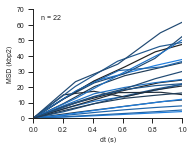

In [26]:
protein = 'MCM'
fig,axes = plt.subplots()

for item in dfs_msd[:]:
    sns.lineplot(x='dtime', y='msd', data=item, ax=axes)
axes.set_xlim(0,1)
axes.set_ylim(0,70)
#axes.set_title('MSD vs $\Delta$ t')
axes.set_xlabel('dt (s)')
axes.set_ylabel('MSD (kbp2)')
axes.text(0.05, 0.95, f'n = {len(dfs_msd[:])}',
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes)

sns.despine(trim=True)

#save
plt.savefig(dir_out+"S1J_MSD_vs_time.svg",transparent=True)


### Figure S1K: Example trajectories diffusive MCM DH

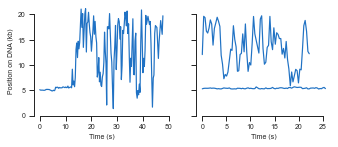

In [27]:
protein = 'MCM'

fig,axes = plt.subplots(1,2,figsize=(5.34,2),sharey=True)

# panel A - Example Molecule free

for prefix in DnaMoleculeArchive.instances[0].molecules[11].prefixes:
    try:
        sns.lineplot(x=prefix + 'Time (s)', y=DnaMoleculeArchive.instances[0].molecules[11].df[prefix + 'Position_on_DNA']/1000, data=DnaMoleculeArchive.instances[0].molecules[11].df,ax=axes[0],
                    color=palettes[protein][1])
    except:
        continue
#axes[0].set_xlim(0,25)
axes[0].set_ylim(0,21.5)
#axes[0].set_title('Example Molecule 1')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Position on DNA (kb)')

# panel B -  Example Molecule with second MCM

for prefix in DnaMoleculeArchive.instances[0].molecules[15].prefixes:
    try:
        sns.lineplot(x=prefix + 'Time (s)', y=DnaMoleculeArchive.instances[0].molecules[15].df[prefix + 'Position_on_DNA']/1000, data=DnaMoleculeArchive.instances[0].molecules[15].df,ax=axes[1],
                    color=palettes[protein][1])
    except:
        continue
#axes[1].set_xlim(0,25)
axes[1].set_ylim(0,21.5)
#axes[1].set_title('Example Molecule 2')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Position on DNA (kb)')


sns.despine(trim=True)

#save
plt.savefig(dir_out+"S1K_ExampleMolecule_sliding.svg",transparent=True)
